# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import Concord as ccd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_clustereasy_singlebatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Mar04-1901'

In [4]:
state_key = 'cluster'
batch_key = 'batch'
state_type = 'cluster'
leiden_key='leiden'
batch_type = 'batch_specific_features'
distribution = 'normal'
n_cells = [100,100,50]
n_genes = [100,100,50]
state_dispersion = [4.0,2.0,2.0]

In [6]:
from Concord.utils.simulation import Simulation

sim = Simulation(n_cells=n_cells, n_genes=n_genes,
                 n_batches=1, n_states=3, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=5, 
                 state_min_level=0,
                 state_dispersion=state_dispersion, 
                 program_structure="uniform",
                 program_on_time_fraction=0.3,
                 trajectory_program_num=4,
                 trajectory_loop_to=[1],
                 batch_feature_frac=0.15,
                 batch_distribution = distribution,
                 batch_type=batch_type, 
                 batch_level=[5,5], 
                 batch_dispersion=[3.0, 3.0], 
                 global_non_specific_gene_fraction=0.1,
                 pairwise_non_specific_gene_fraction=None,
                 non_neg=True, to_int=True,
                 seed=seed)

# Generate the simulated data
adata, adata_state = sim.simulate_data()

Concord.utils.simulation - INFO - Simulating 3 clusters with distribution: normal with mean expression 5 and dispersion [4.0, 2.0, 2.0].
Concord.utils.simulation - INFO - Adding non-specific genes to the expression matrix. Note this will increase gene count compared to the specified value.
Concord.utils.simulation - INFO - Simulating batch-specific features effect on batch_1 by appending a set of batch-specific genes with normal distributed value with level 5 and dispersion 3.0.


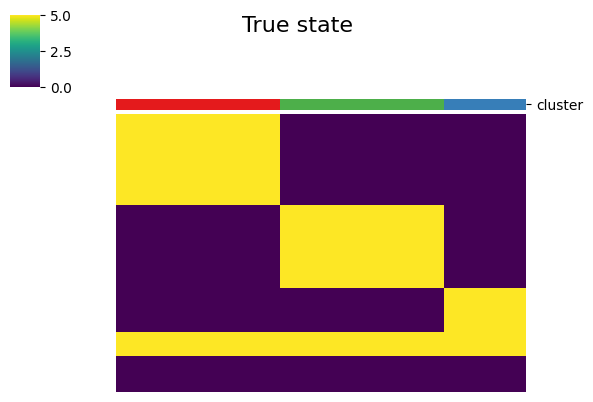

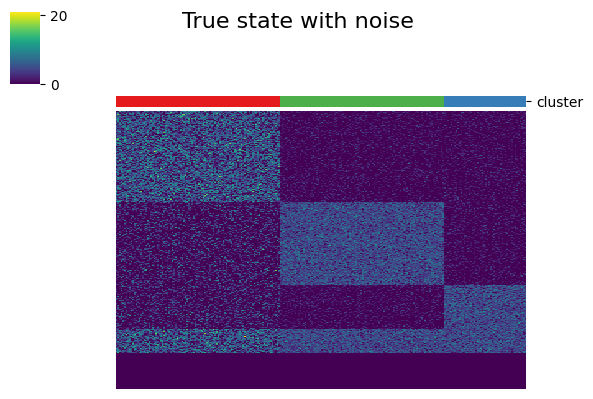

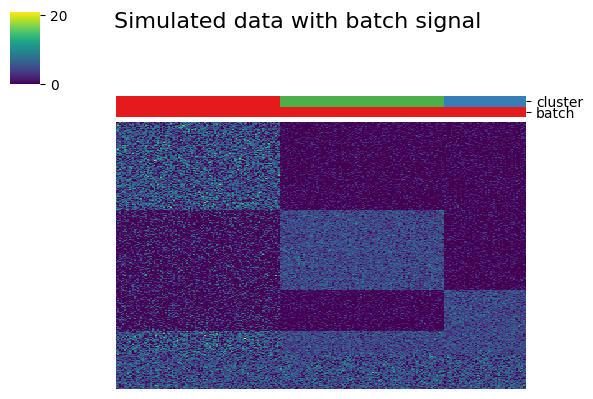

In [7]:
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(6, 4), dpi=300)

In [8]:
adata.shape

(250, 287)

### No batch effect, no noise

In [9]:
n_components = 15
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata, resolution=1.0, key_added=leiden_key, random_state=seed)
#adata.obs[leiden_key] = adata_state.obs[leiden_key]

Concord - INFO - PCA performed on source data with 15 components
Concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']
Concord - INFO - UMAP embedding stored in adata.obsm['UMAP_no_noise']


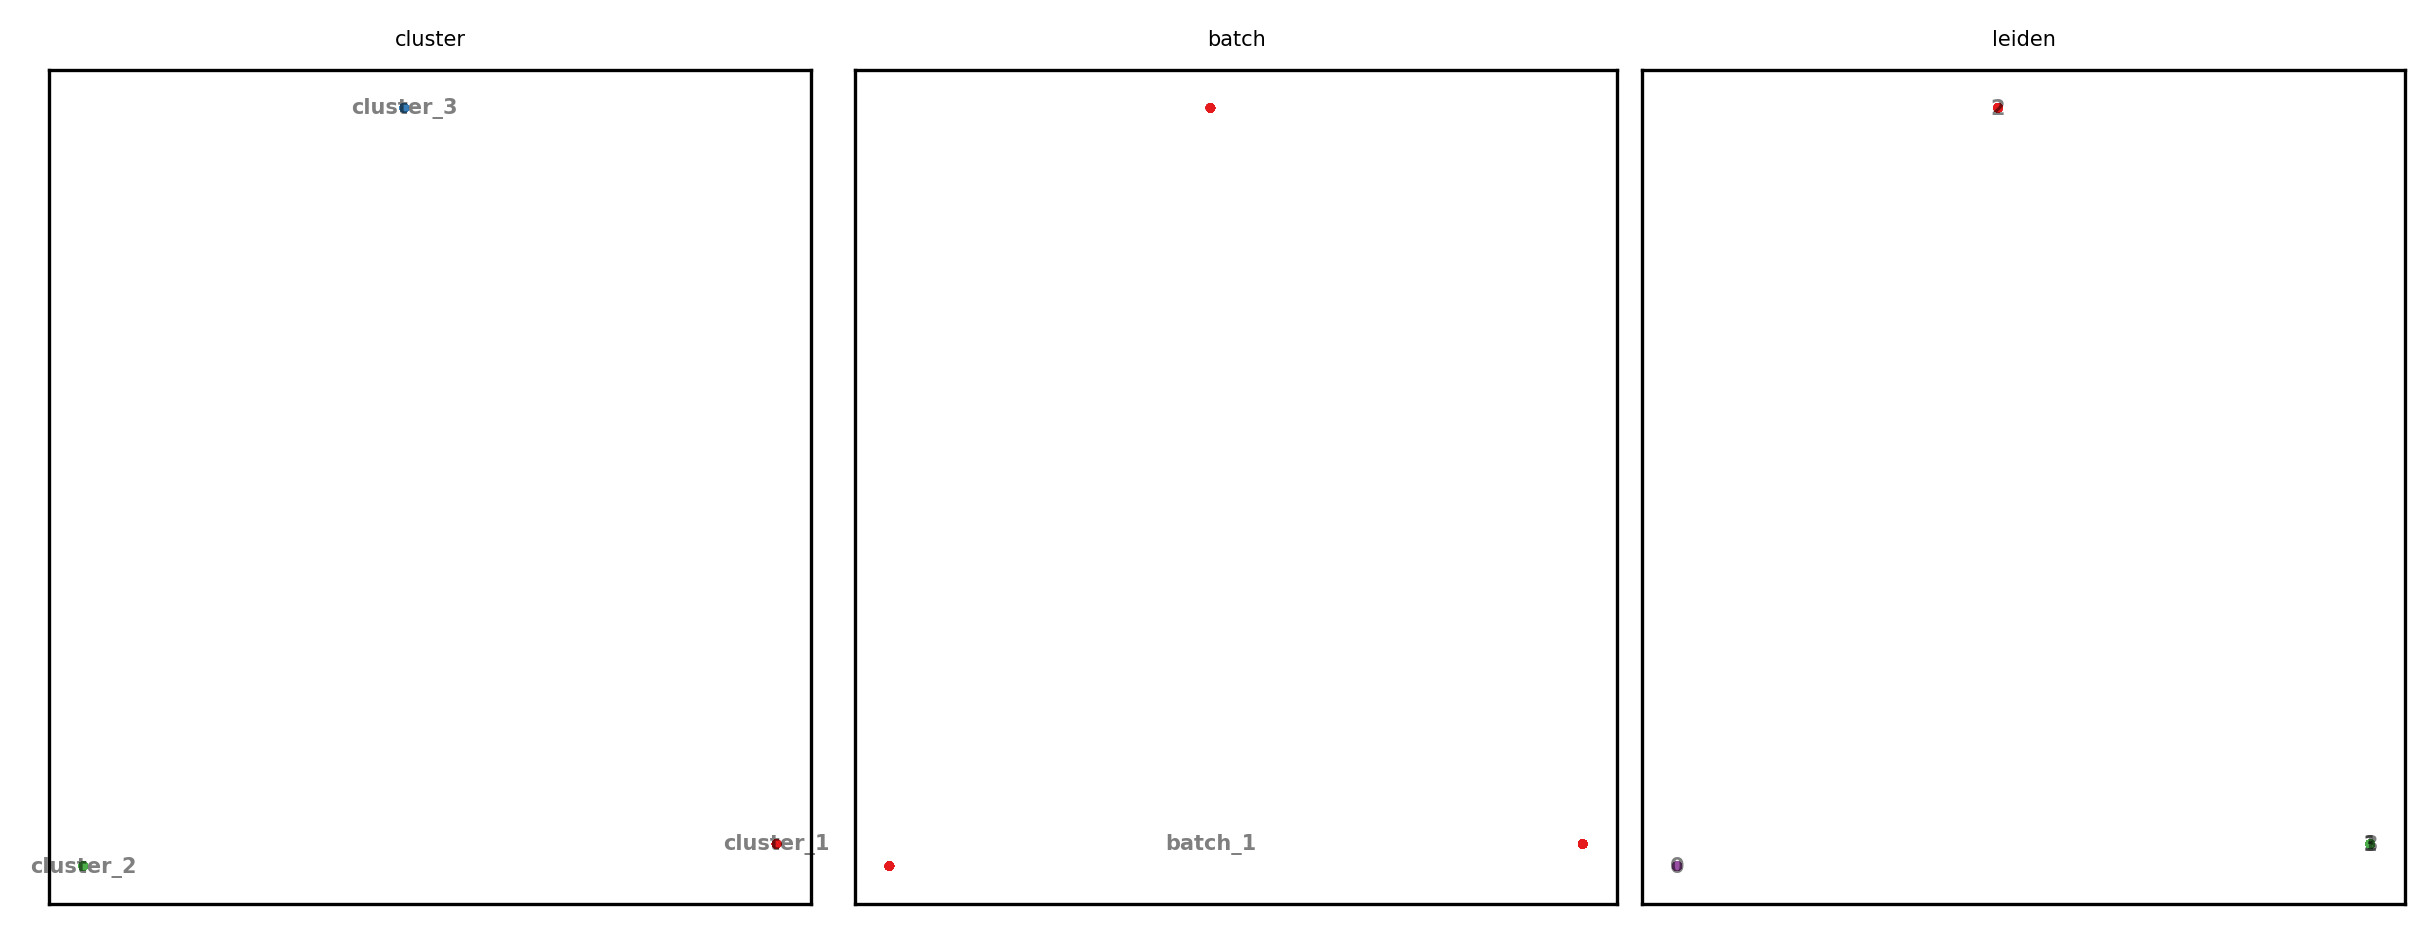

In [10]:
show_basis = 'PCA_no_noise'
show_cols = [state_key, batch_key, leiden_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

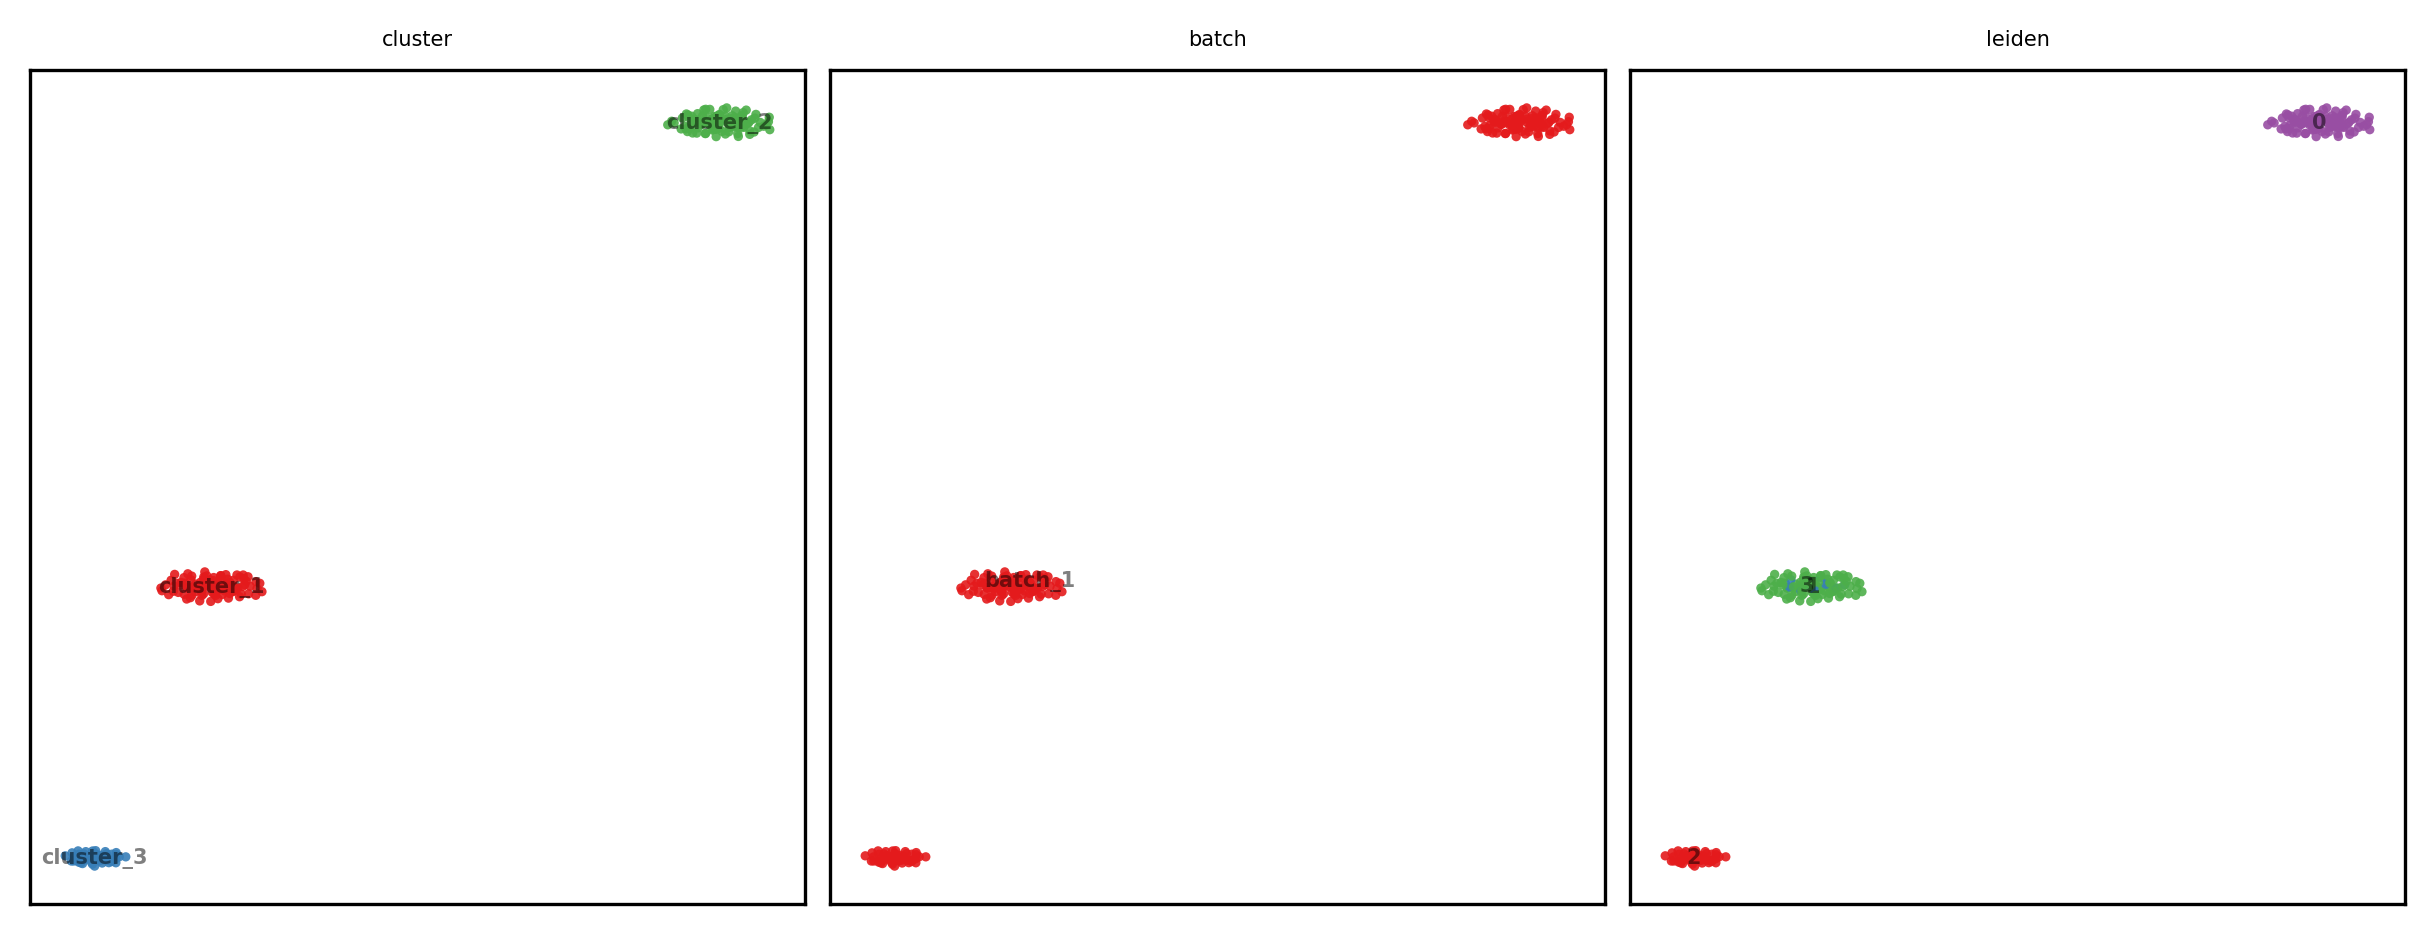

In [11]:
show_basis = 'UMAP_no_noise'

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.svg"
)

### noise added, Run all methods

In [12]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder", "Concord-pknn0"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]
combined_keys

['no_noise',
 'wt_noise',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'Concord',
 'Concord-decoder',
 'Concord-pknn0']

In [ ]:
time_log = ccd.ul.run_dimensionality_reduction_pipeline(
    adata,
    source_key="X",
    methods=run_methods,
    n_components=15,
    random_state=seed,
    device=device,
    save_dir=save_dir,
    concord_epochs=15,
    concord_min_pid=0.95
)

Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.


Concord.model.knn - WARNING - FAISS not found. Using sklearn for k-NN computation.
Concord.model.dataloader - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
p_intra_knn: 0.0


Epoch 0 Training: 3it [00:00, 40.64it/s, loss=4.4]
Epoch 14 Training: 100%|██████████| 3/3 [00:00<00:00, 363.24it/s, loss=3.97]


In [24]:
# Run umap and PCA for all latent embeddings
adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']
max_pc = 15
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
    if not any(substring in basis for substring in ['PHATE', 'PCA']):
        if basis in adata.layers.keys():
            n_pc = min(min(adata.layers[basis].shape[1], adata.shape[0]) - 1, max_pc)
        else:
            n_pc = min(min(adata.obsm[basis].shape[1], adata.shape[0]) - 1, max_pc)
        
        print("n_pc", n_pc)
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)


Running UMAP and PCA for no_noise
n_pc 15
Running UMAP and PCA for wt_noise
n_pc 15
Running UMAP and PCA for DiffusionMap
n_pc 14
Running UMAP and PCA for NMF
n_pc 14
Running UMAP and PCA for FactorAnalysis
n_pc 14
Running UMAP and PCA for FastICA
n_pc 14
Running UMAP and PCA for LDA
n_pc 14
Running UMAP and PCA for ZIFA
n_pc 14
Running UMAP and PCA for scVI
n_pc 15
Running UMAP and PCA for PHATE
Running UMAP and PCA for Concord
n_pc 14
Running UMAP and PCA for Concord-decoder
n_pc 14
Running UMAP and PCA for Concord-pknn0
n_pc 14


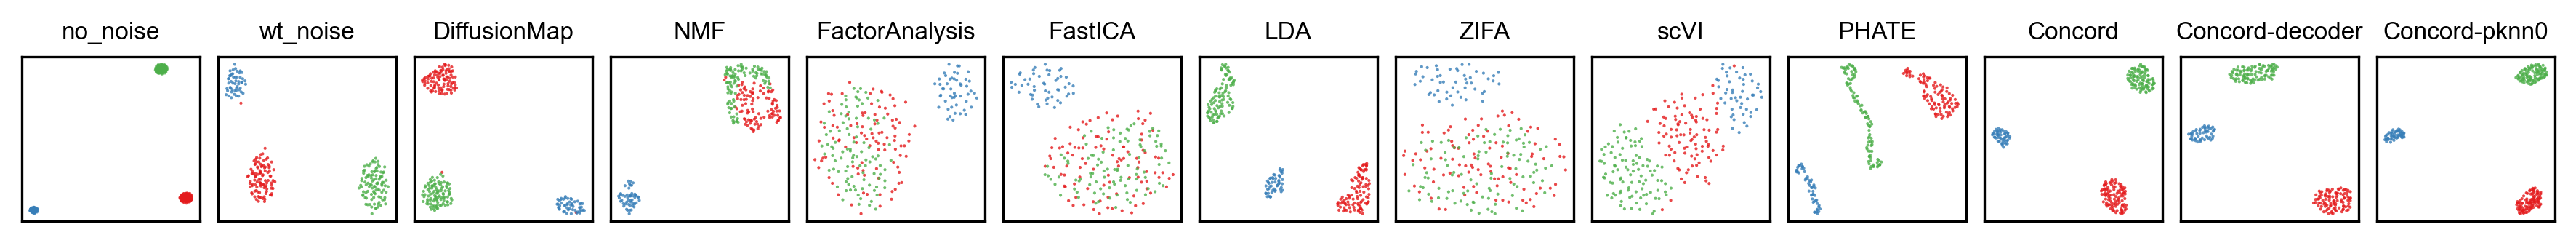

In [25]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = [state_key]
#basis_types = ['', 'PAGA', 'KNN', 'PCA', 'UMAP']
basis_types = ['UMAP']
font_size=8
point_size=4
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = 1
pal = {'state':'tab10'}
k=15
edges_color='grey'
edges_width=0.05
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=1,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix,
        save_format='svg'
    )


In [18]:
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord', path=batch_indices, sigma=2)
adata.obsm['Concord_sorted'] = adata.obsm['Concord'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord-decoder', path=batch_indices, sigma=2)
adata.obsm['Concord-decoder_sorted'] = adata.obsm['Concord-decoder'][:, feature_order]

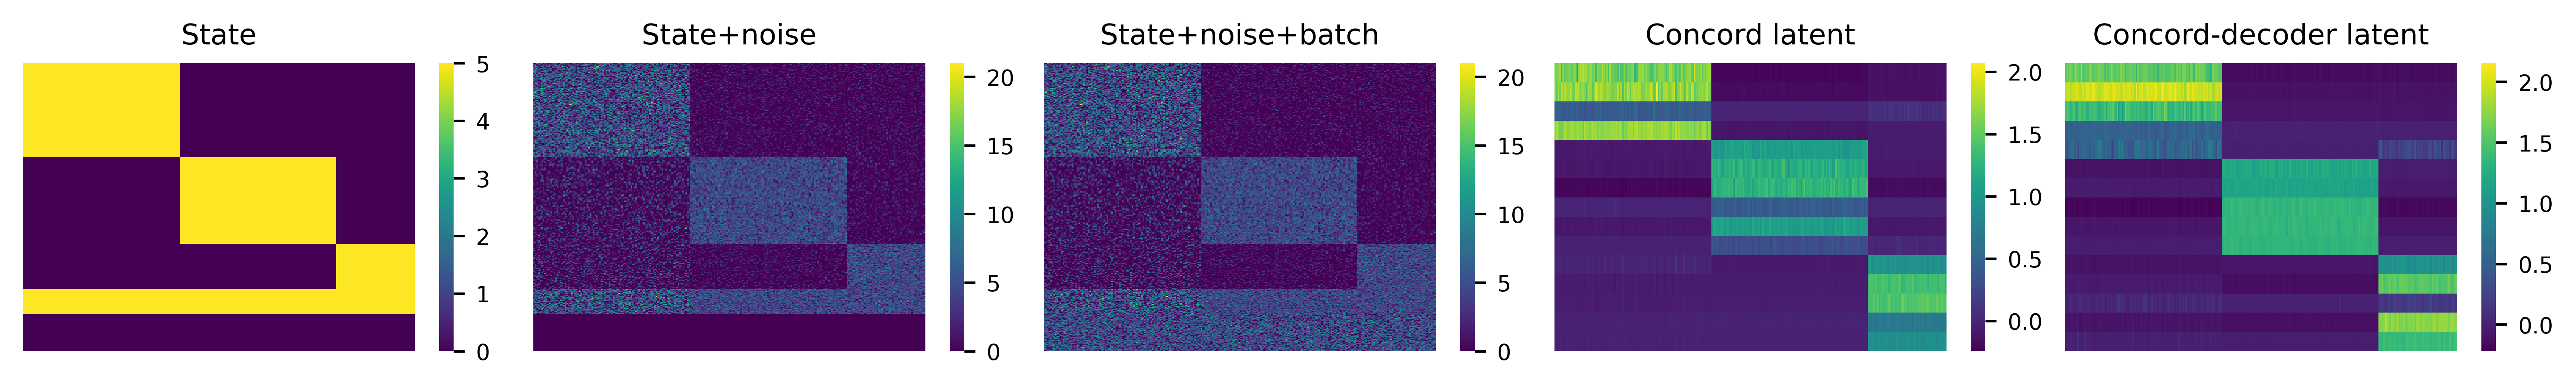

In [19]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

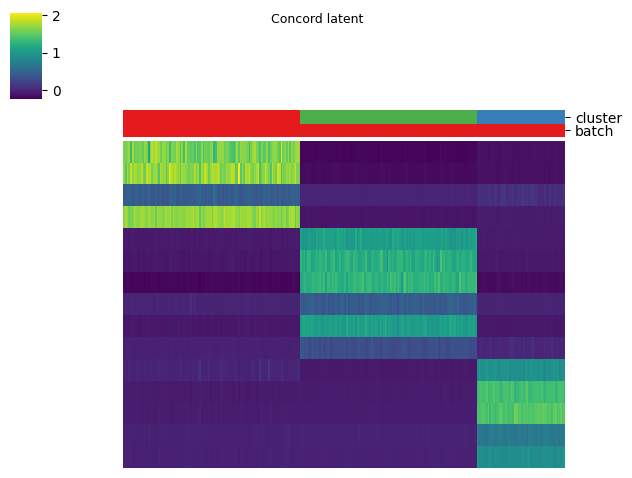

In [20]:
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=True, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=f"heatmap_wt_annot_{file_suffix}.svg", figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)

In [26]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

'Feb06-1037'

# Evaluation

In [6]:
adata = sc.read(data_dir / f"adata_Feb06-1037.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Feb06-1037.h5ad")

### Topology

Run topological analysis pipeline:

In [10]:
run_methods = ["PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
             "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
             "Concord", "Concord-decoder"]
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys_topo = ['no_noise_PCA', 'wt_noise_PCA'] + [key for key in run_methods if key not in exclude_keys]
combined_keys_topo

['no_noise_PCA',
 'wt_noise_PCA',
 'DiffusionMap',
 'NMF',
 'FactorAnalysis',
 'FastICA',
 'LDA',
 'ZIFA',
 'scVI',
 'PHATE',
 'Concord',
 'Concord-decoder']

In [11]:
homology_dimensions = [0,1,2]
diagrams = {}
for key in combined_keys_topo:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

Computing persistent homology for no_noise_PCA
Computing persistent homology for wt_noise_PCA
Computing persistent homology for DiffusionMap
Computing persistent homology for NMF
Computing persistent homology for FactorAnalysis
Computing persistent homology for FastICA
Computing persistent homology for LDA
Computing persistent homology for ZIFA
Computing persistent homology for scVI
Computing persistent homology for PHATE
Computing persistent homology for Concord


KeyboardInterrupt: 

In [34]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

PosixPath('../save/dev_simulation_clustereasy_singlebatch-Feb06/topology_diagrams_Feb06-1037.pkl')

In [12]:
import pickle
with open(Path('../save/dev_simulation_clustereasy_singlebatch-Feb06/topology_diagrams_Feb06-1037.pkl'), 'rb') as f:
    diagrams = pickle.load(f)

In [13]:
expected_betti_numbers = [2,0,0]
max_betti = np.max(expected_betti_numbers)
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=expected_betti_numbers, save_dir=save_dir, file_suffix=file_suffix)
topology_metrics = topology_results['combined_metrics']#.drop(index=['no_noise_PCA', 'wt_noise_PCA'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=2 * max_betti)
topology_metrics

Betti curve              Betti number
                    Entropy     Variance  L1 distance
Method                                               
Concord            1.290178   452.084600            0
Concord-decoder    1.499148   328.775600            0
Concord-pknn0      1.601494   462.968867            0
DiffusionMap       3.113031  2056.906767            1
FactorAnalysis     3.523256  2190.371800            4
FastICA            3.413886  2411.192367            4
LDA                2.347651   720.339167            0
NMF                3.337499  1597.470967            1
PHATE              1.515994   218.354233            1
ZIFA               3.589954  2873.781667            4
no_noise_PCA       1.439927     3.407200            0
scVI               3.589512  2522.183700            4
wt_noise_PCA       3.242757  2130.673133            4

In [14]:
topology_df = topology_metrics.copy()

# Rename row name "no_noise_PCA" to "no_noise", "wt_noise_PCA" to "wt_noise"
topology_df.rename(
    index={
        "no_noise_PCA": "no_noise",
        "wt_noise_PCA": "wt_noise"
    },
    inplace=True
)

topology_df[("Topological metrics", "Betti curve stability")] = topology_df["Betti curve"][
    ["Entropy"]
]
topology_df[("Topological metrics", "Betti number accuracy")] = topology_df["Betti number"][
    ["L1 distance"]
]

topology_df.drop(
    columns=[
        ("Betti curve", "Variance"),
        ("Betti curve", "Entropy"),
        ("Betti number", "L1 distance")
    ],
    inplace=True
)

topology_df


Topological metrics                      
                Betti curve stability Betti number accuracy
Method                                                     
Concord                      1.290178                     0
Concord-decoder              1.499148                     0
Concord-pknn0                1.601494                     0
DiffusionMap                 3.113031                     1
FactorAnalysis               3.523256                     4
FastICA                      3.413886                     4
LDA                          2.347651                     0
NMF                          3.337499                     1
PHATE                        1.515994                     1
ZIFA                         3.589954                     4
no_noise                     1.439927                     0
scVI                         3.589512                     4
wt_noise                     3.242757                     4

In [10]:
agg_name1 = ''
agg_name2 = 'Topology Score'
drop_methods = ['Concord-decoder', 'Concord-pknn0']
topology_scores = ccd.ul.benchmark_stats_to_score(topology_df.drop(index=drop_methods), min_max_scale=True, one_minus=True, aggregate_score=False, aggregate_score_name1=None, aggregate_score_name2=None, rank=False, rank_col=None, name_exact=False)
# Weight the metrics
topology_scores[("", "Topology Score")] = topology_scores[("Topological metrics", "Betti curve stability")]*0.2 + topology_scores[("Topological metrics", "Betti number accuracy")]*0.8
topology_scores.sort_values(by=("", "Topology Score"), ascending=False, inplace=True)
topology_scores

Topological metrics                                     
               Betti curve stability Betti number accuracy Topology Score
Method                                                                   
Concord                     1.000000                  1.00       1.000000
no_noise                    0.934885                  1.00       0.986977
LDA                         0.540184                  1.00       0.908037
PHATE                       0.901810                  0.75       0.780362
DiffusionMap                0.207378                  0.75       0.641476
NMF                         0.109774                  0.75       0.621955
wt_noise                    0.150970                  0.00       0.030194
FastICA                     0.076559                  0.00       0.015312
FactorAnalysis              0.029002                  0.00       0.005800
scVI                        0.000193                  0.00       0.000039
ZIFA                        0.000000                  0.00       0.000000

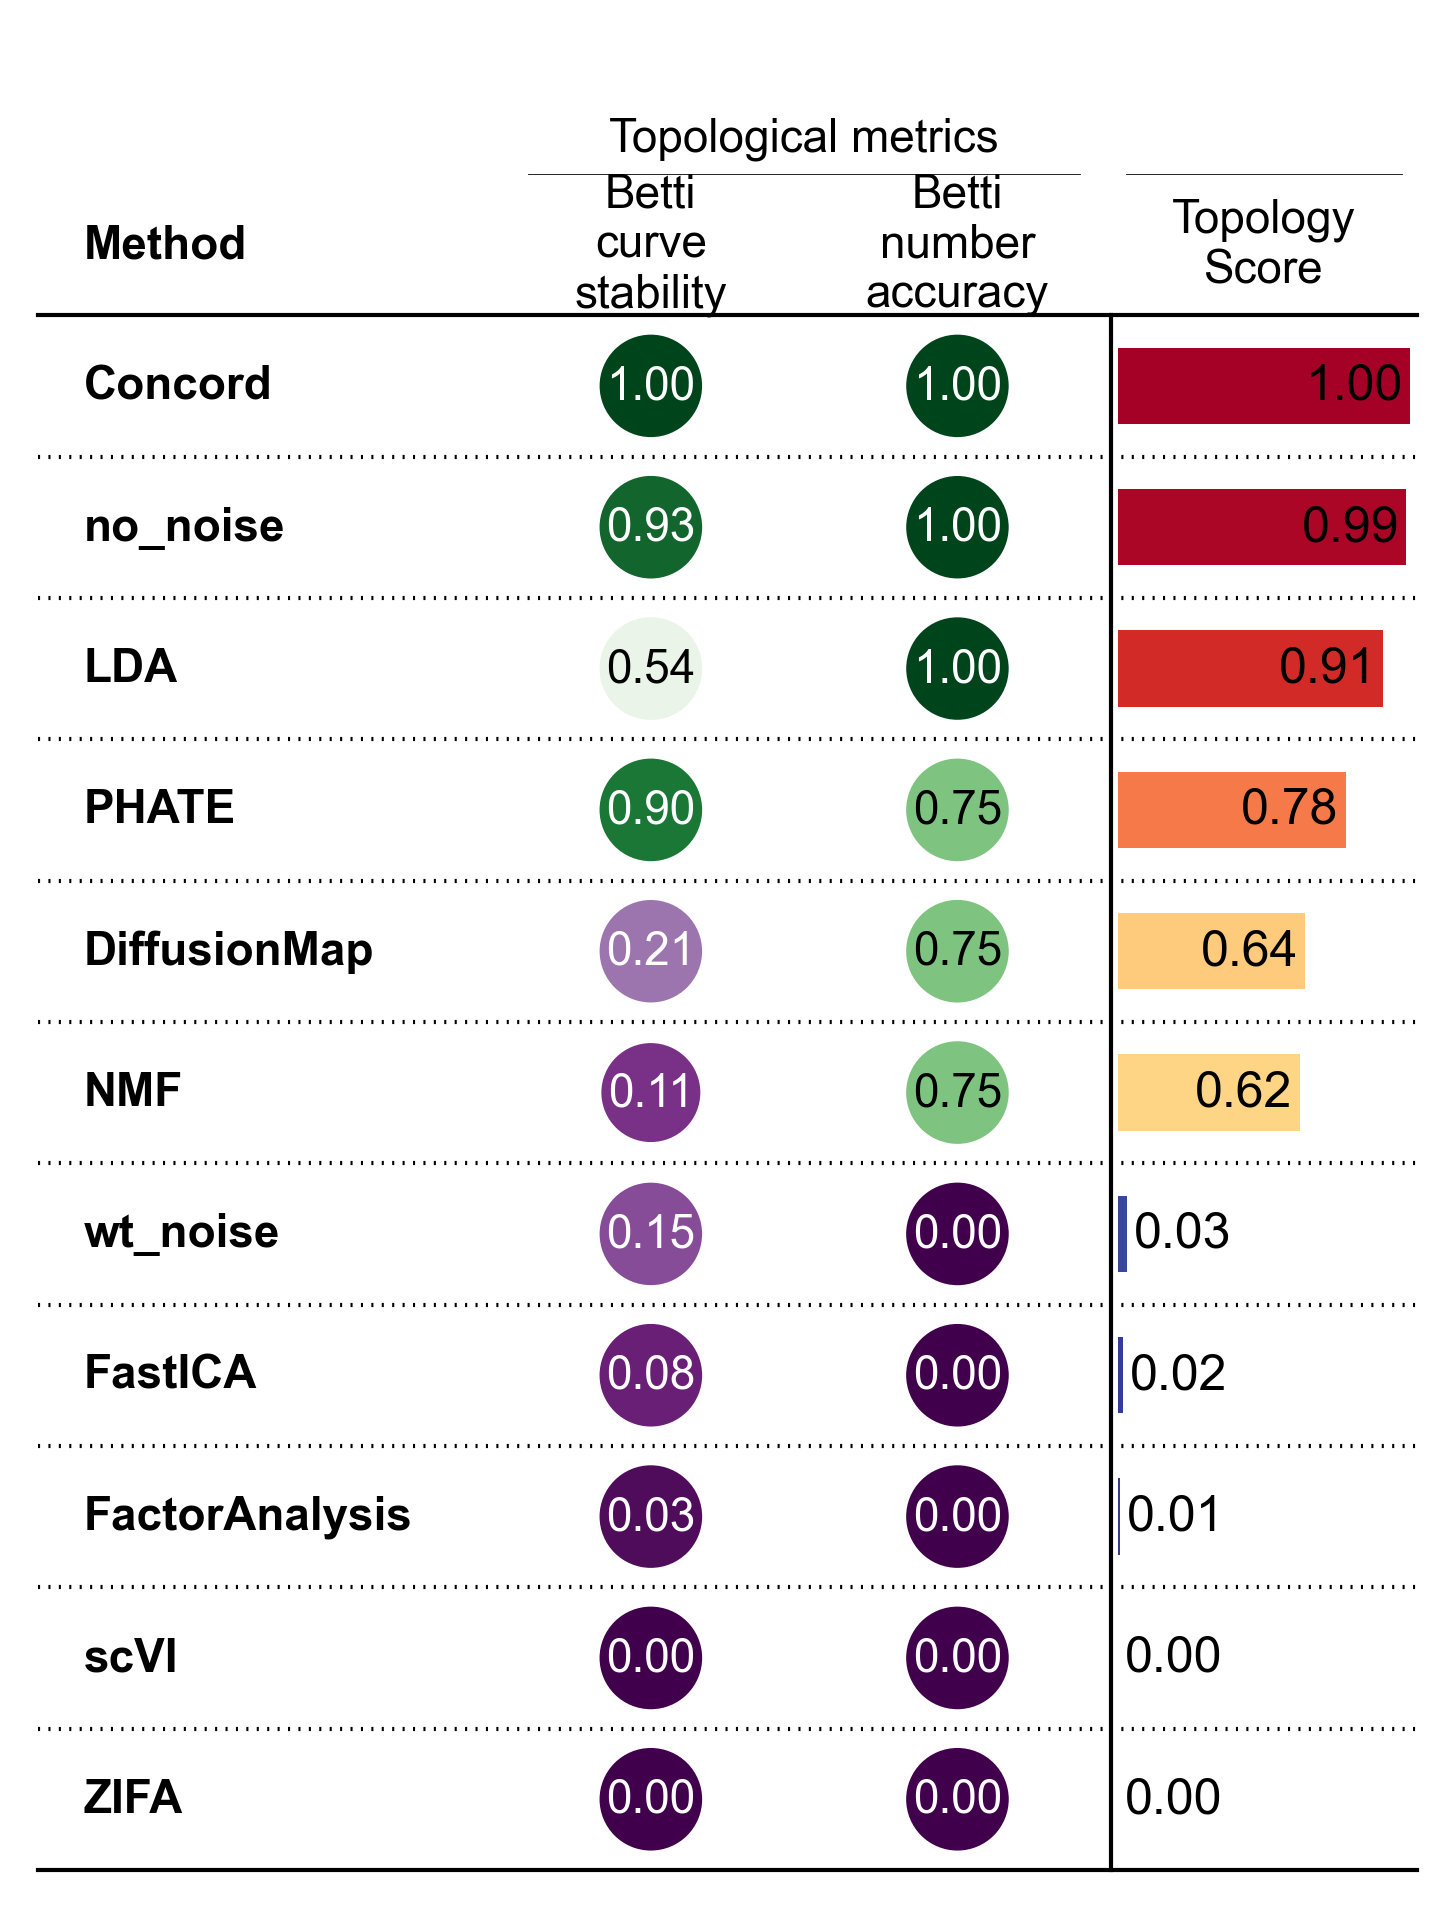

In [15]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 8), dpi=300)

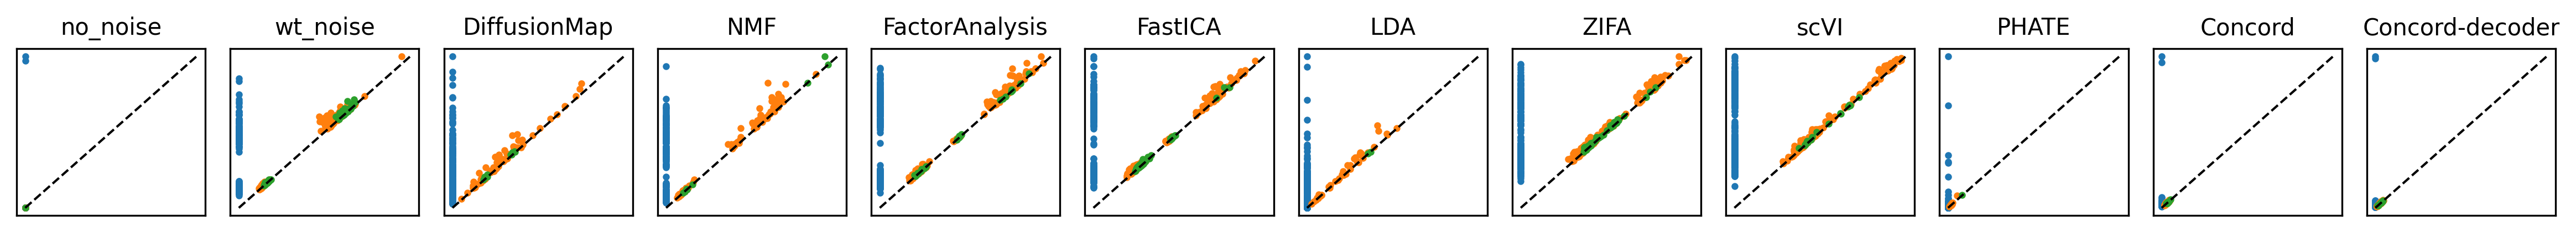

In [15]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys_topo}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('_PCA', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=12, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.svg", legend=False, label_axes=False, axis_ticks=False)

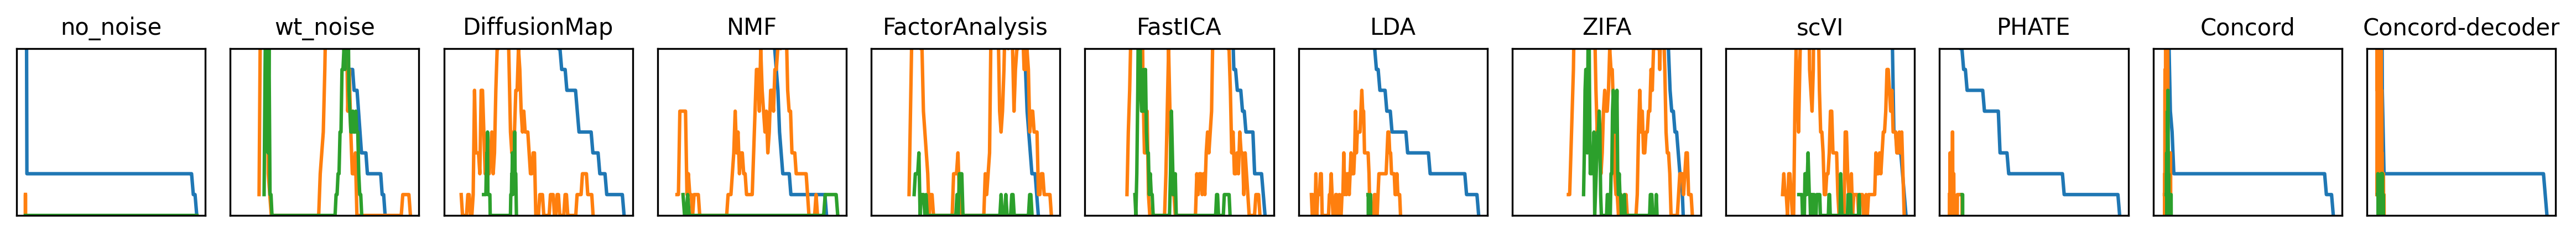

In [16]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=12, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

# Geomtric Features 

### Integrated benchmark pipeline

In [13]:
geometry_metrics = ['cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
#groundtruth_key = 'wt_noise'
groundtruth_key = 'no_noise'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      ground_truth_dispersion_key = 'wt_noise',
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      state_key = state_key,
                                      batch_key = batch_key,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

Concord - INFO - Computing cell distance correlation


Concord - INFO - Computing local vs distal correlation
Concord - INFO - Computing trustworthiness
Concord - INFO - Computing cluster centroid distances correlation
Concord - INFO - Computing state dispersion correlation


In [14]:
geometry_full['state_dispersion_corr']

{'dispersion': {'no_noise': {'cluster_1': 0.0,
   'cluster_2': 0.0,
   'cluster_3': 0.0},
  'wt_noise': {'cluster_1': 7.492719163763067,
   'cluster_2': 2.0321968641114982,
   'cluster_3': 1.6269142857142858},
  'DiffusionMap': {'cluster_1': 0.002229226,
   'cluster_2': 0.004494661,
   'cluster_3': 0.0025984107},
  'NMF': {'cluster_1': 0.027319405,
   'cluster_2': 0.00092314056,
   'cluster_3': 0.0006555676},
  'FactorAnalysis': {'cluster_1': 1.5683134437777608,
   'cluster_2': 0.13106894339653427,
   'cluster_3': 0.10177736756436234},
  'FastICA': {'cluster_1': 1.8795166,
   'cluster_2': 0.20634414,
   'cluster_3': 0.17093179},
  'LDA': {'cluster_1': 0.016380334,
   'cluster_2': 0.00020482173,
   'cluster_3': 0.00054874807},
  'ZIFA': {'cluster_1': 1.3318312266562347,
   'cluster_2': 0.25290604792918986,
   'cluster_3': 0.31780603765605436},
  'scVI': {'cluster_1': 0.80036724,
   'cluster_2': 0.20203988,
   'cluster_3': 0.2330906},
  'PHATE': {'cluster_1': 2.3115266585043267e-05,
   '

In [15]:
# Simplify the dataframe by computing average for each metric
geometry_df = ccd.ul.simplify_geometry_benchmark_table(geometry_df)
geometry_df = geometry_df.drop(columns=[('Geometric metrics', 'State distance correlation')]) # Redundant with cell distance correlation
geometry_df

Geometric metrics                  \
                Cell distance correlation Trustworthiness   
no_noise                         1.000000        0.937345   
wt_noise                         0.779337        0.929598   
DiffusionMap                     0.405354        0.768089   
NMF                              0.277742        0.772377   
FactorAnalysis                   0.505632        0.702927   
FastICA                          0.449253        0.699868   
LDA                              0.736815        0.903969   
ZIFA                             0.352332        0.693986   
scVI                             0.613583        0.767530   
PHATE                            0.816818        0.904705   
Concord                          0.859510        0.936479   
Concord-decoder                  0.871182        0.917445   
Concord-pknn0                    0.934116        0.909080   

                                              
                State dispersion correlation  
no_noise                                 NaN  
wt_noise                            1.000000  
DiffusionMap                       -0.469868  
NMF                                 0.999529  
FactorAnalysis                      0.999671  
FastICA                             0.999681  
LDA                                 0.610031  
ZIFA                                0.608888  
scVI                                0.609169  
PHATE                               0.885411  
Concord                             0.988875  
Concord-decoder                     0.586885  
Concord-pknn0                       0.999539

In [16]:
agg_name1 = ''
agg_name2 = 'Geometric Score'
drop_methods = ['Concord-decoder', 'Concord-pknn0']
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df.drop(index=drop_methods), fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
geometry_scores


Geometric metrics                  \
               Cell distance correlation Trustworthiness   
Concord                         0.859510        0.936479   
wt_noise                        0.779337        0.929598   
PHATE                           0.816818        0.904705   
LDA                             0.736815        0.903969   
FactorAnalysis                  0.505632        0.702927   
FastICA                         0.449253        0.699868   
NMF                             0.277742        0.772377   
scVI                            0.613583        0.767530   
no_noise                        1.000000        0.937345   
ZIFA                            0.352332        0.693986   
DiffusionMap                    0.405354        0.768089   

                                                             
               State dispersion correlation Geometric Score  
Concord                            0.988875        0.928288  
wt_noise                           1.000000        0.902978  
PHATE                              0.885411        0.868978  
LDA                                0.610031        0.750272  
FactorAnalysis                     0.999671        0.736077  
FastICA                            0.999681        0.716268  
NMF                                0.999529        0.683216  
scVI                               0.609169        0.663427  
no_noise                           0.000000        0.645782  
ZIFA                               0.608888        0.551735  
DiffusionMap                      -0.469868        0.234525

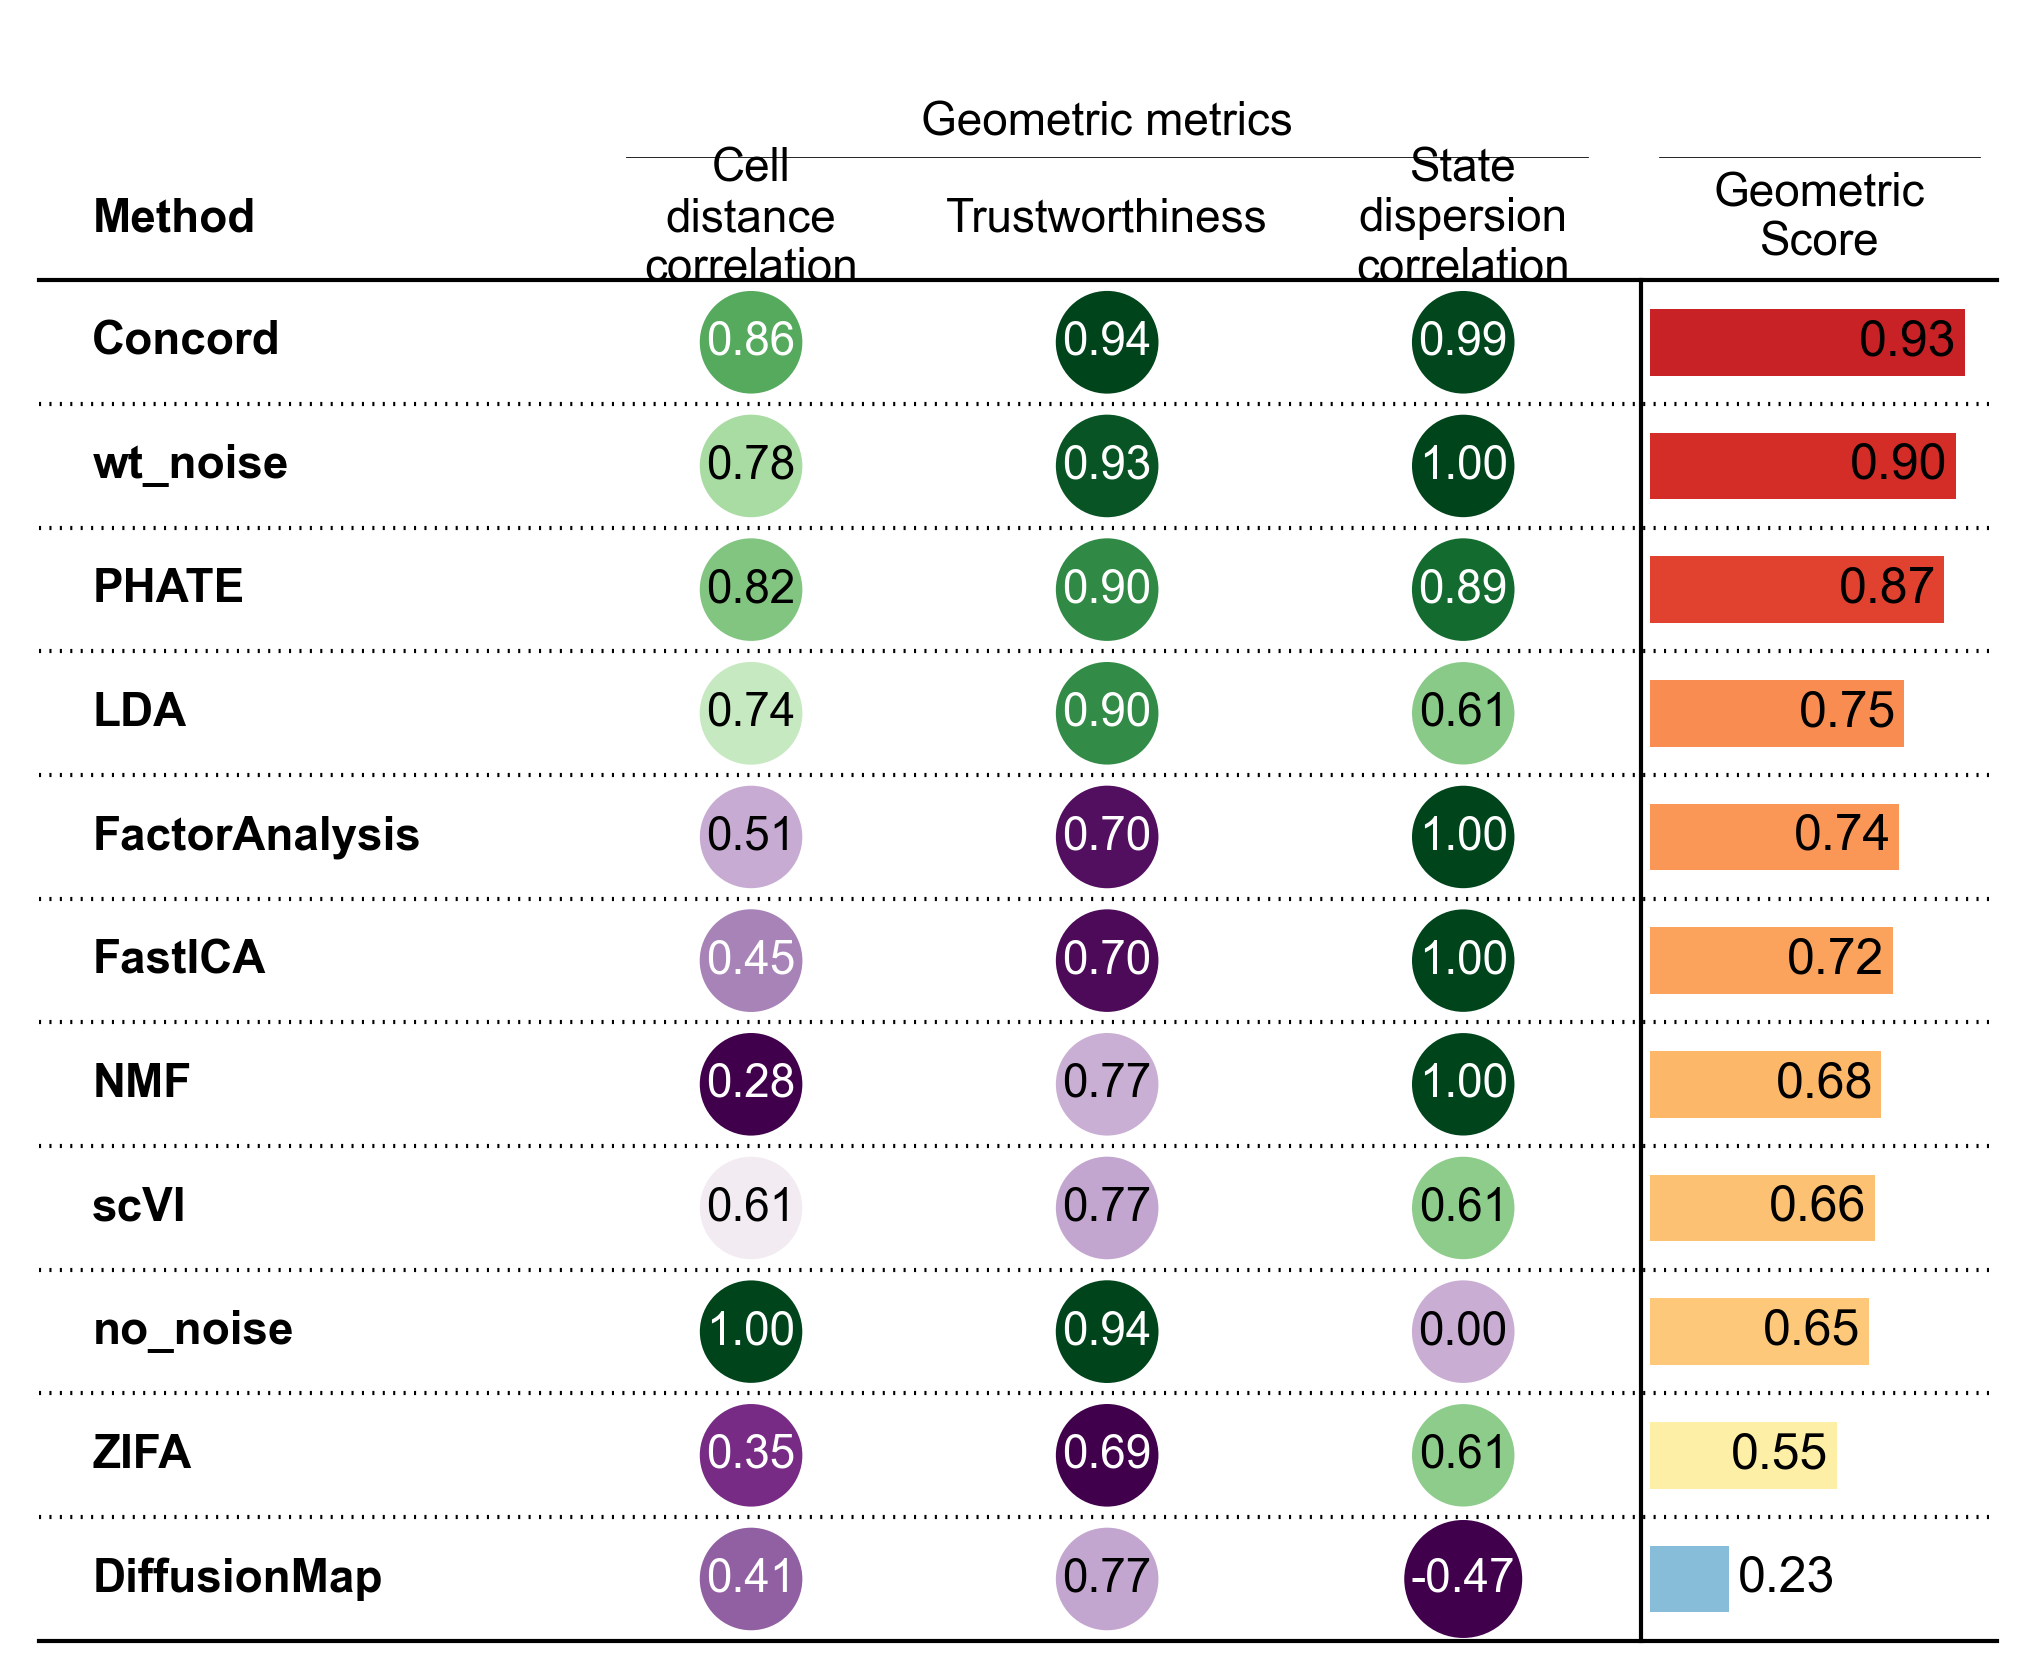

In [25]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(8.5, 7), dpi=300)

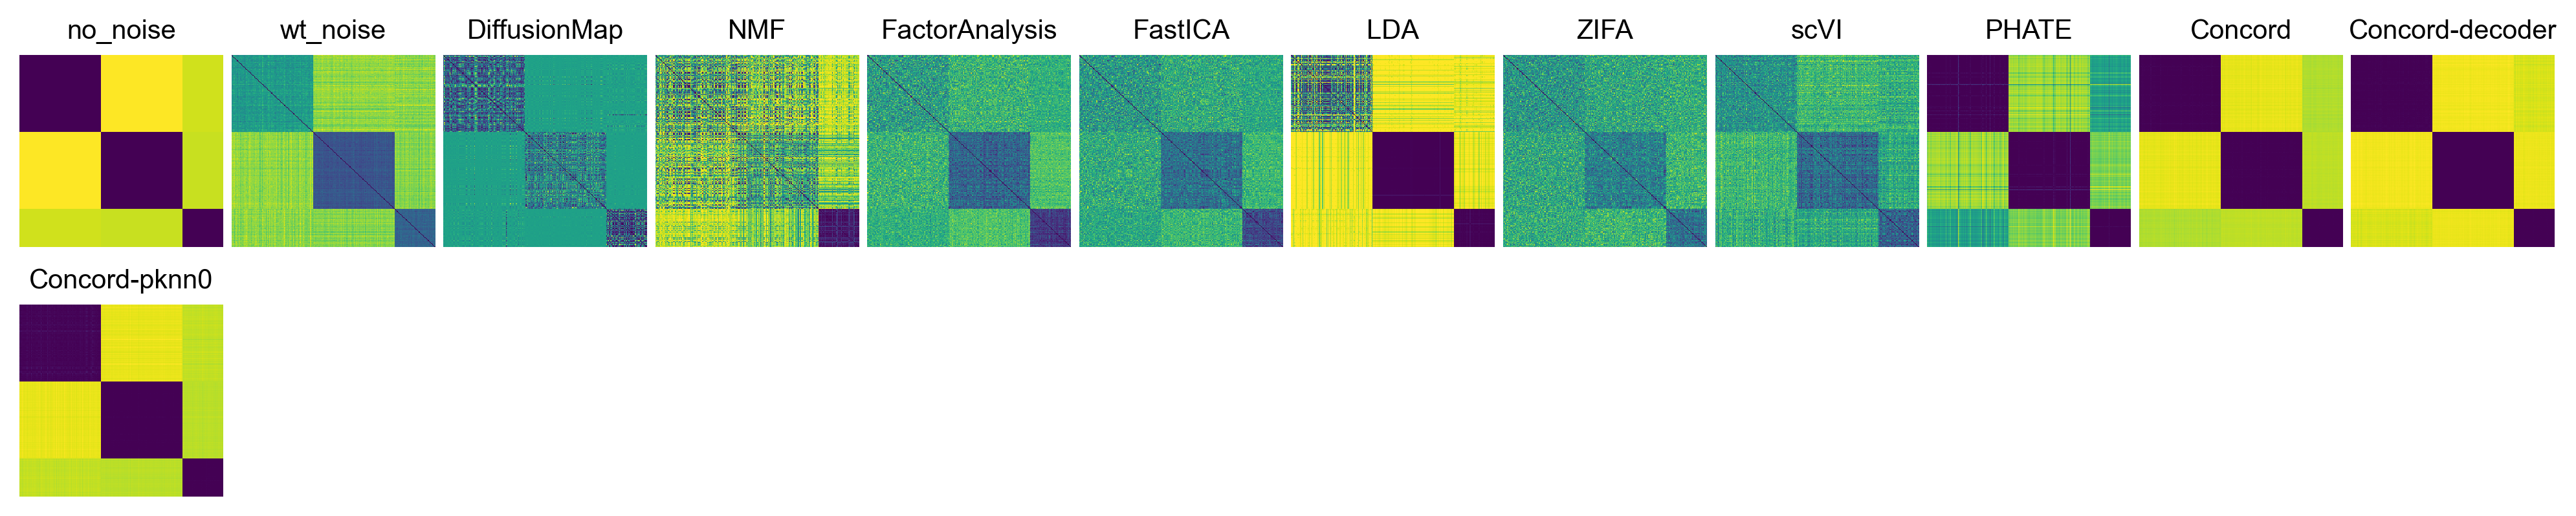

In [51]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 12, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.svg")

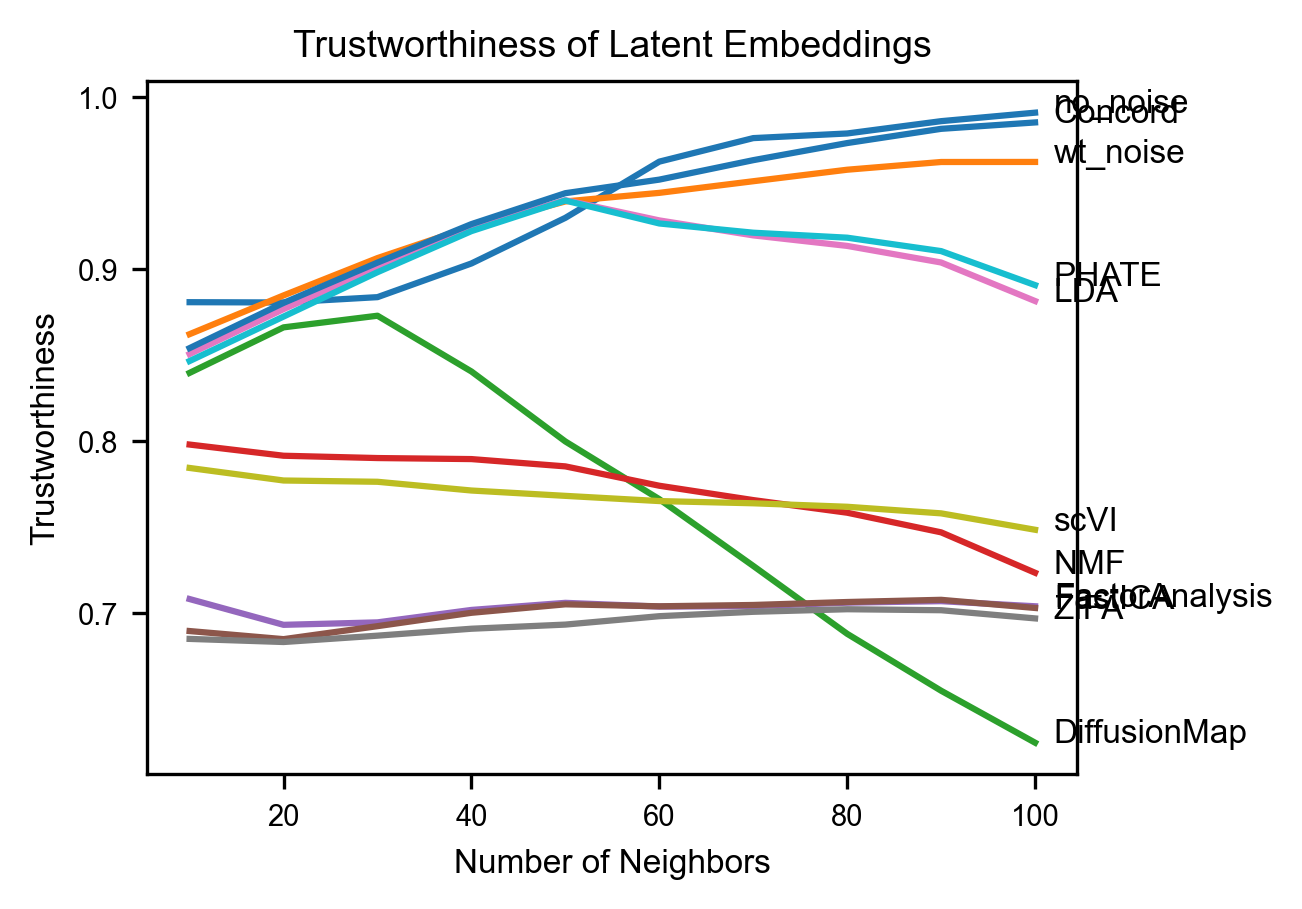

In [52]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
drop_methods = ['Concord-pknn0', 'Concord-decoder']
# Drop row with column 'Embedding' in drop_methods
trustworthiness_scores = trustworthiness_scores[~trustworthiness_scores['Embedding'].isin(drop_methods)]
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=False, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

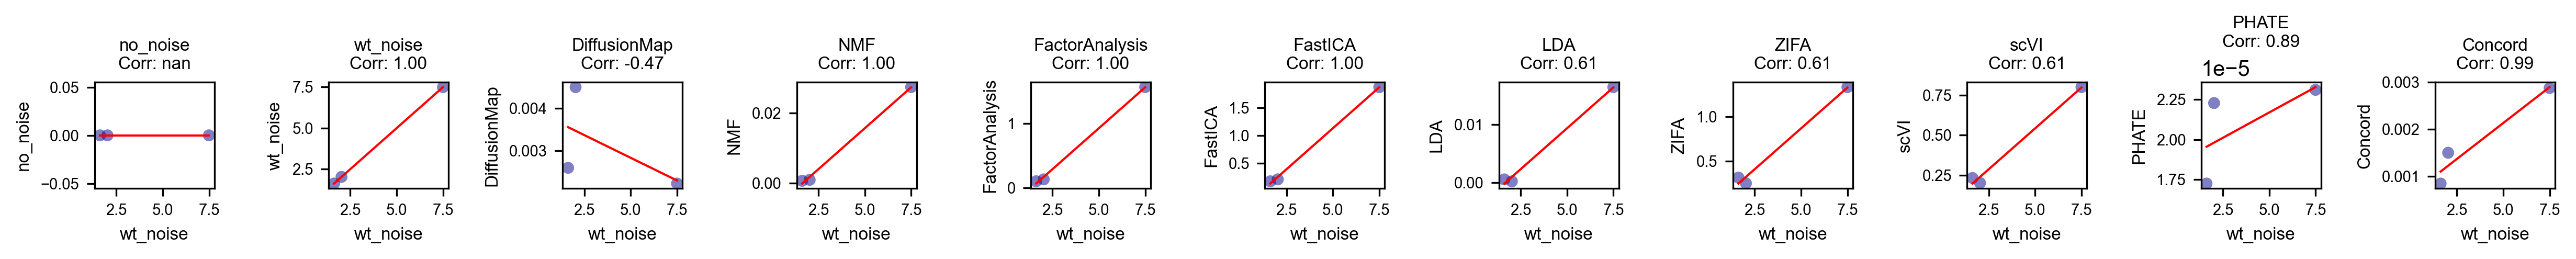

In [28]:
# Drop value with keys in drop_methods from dictionary
import matplotlib.pyplot as plt
dispersion_dict = geometry_full['state_dispersion_corr']['dispersion']
dispersion_dict = {key: dispersion_dict[key] for key in dispersion_dict if key not in drop_methods}
correlation_df = geometry_full['state_dispersion_corr']['correlation'].drop(index=drop_methods)
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_geometry_scatter(
        data_dict = dispersion_dict,
        correlation= correlation_df,
        s=30, c='darkblue',
        ground_key = 'wt_noise',
        linear_fit = True,
        n_cols = 11, figsize=(1.5,1.75), dpi=300, save_path=save_dir / f"state_dispersion_scatter_{groundtruth_key}_{file_suffix}.pdf")

## Combine all metrics

In [17]:
# Combine all metrics into one table
import pandas as pd
all_scores = pd.concat([topology_scores, geometry_scores], axis=1)
all_scores

Topological metrics                                       \
               Betti curve stability Betti number accuracy Topology Score   
Concord                     1.000000                  1.00       1.000000   
no_noise                    0.934885                  1.00       0.986977   
LDA                         0.540184                  1.00       0.908037   
PHATE                       0.901810                  0.75       0.780362   
DiffusionMap                0.207378                  0.75       0.641476   
NMF                         0.109774                  0.75       0.621955   
wt_noise                    0.150970                  0.00       0.030194   
FastICA                     0.076559                  0.00       0.015312   
FactorAnalysis              0.029002                  0.00       0.005800   
scVI                        0.000193                  0.00       0.000039   
ZIFA                        0.000000                  0.00       0.000000   

                       Geometric metrics                  \
               Cell distance correlation Trustworthiness   
Concord                         0.859510        0.936479   
no_noise                        1.000000        0.937345   
LDA                             0.736815        0.903969   
PHATE                           0.816818        0.904705   
DiffusionMap                    0.405354        0.768089   
NMF                             0.277742        0.772377   
wt_noise                        0.779337        0.929598   
FastICA                         0.449253        0.699868   
FactorAnalysis                  0.505632        0.702927   
scVI                            0.613583        0.767530   
ZIFA                            0.352332        0.693986   

                                                             
               State dispersion correlation Geometric Score  
Concord                            0.988875        0.928288  
no_noise                           0.000000        0.645782  
LDA                                0.610031        0.750272  
PHATE                              0.885411        0.868978  
DiffusionMap                      -0.469868        0.234525  
NMF                                0.999529        0.683216  
wt_noise                           1.000000        0.902978  
FastICA                            0.999681        0.716268  
FactorAnalysis                     0.999671        0.736077  
scVI                               0.609169        0.663427  
ZIFA                               0.608888        0.551735

In [18]:
all_scores[('Aggregate score', 'Topology')] = all_scores[('', 'Topology Score')]
all_scores[('Aggregate score', 'Geometry')] = all_scores[('', 'Geometric Score')]
all_scores[('Aggregate score', 'Average Score')] = all_scores["Aggregate score"][["Topology", "Geometry"]].mean(axis=1)
# sort by average score
all_scores.sort_values(by=[('Aggregate score', 'Average Score')], ascending=False, inplace=True)
all_scores.drop(
    columns=[
        ('', 'Topology Score'),
        ('', 'Geometric Score')
    ],
    inplace=True
)
# Save table
all_scores.to_csv(save_dir / f"benchmark_results_{file_suffix}.csv")
all_scores

Topological metrics                        \
               Betti curve stability Betti number accuracy   
Concord                     1.000000                  1.00   
LDA                         0.540184                  1.00   
PHATE                       0.901810                  0.75   
no_noise                    0.934885                  1.00   
NMF                         0.109774                  0.75   
wt_noise                    0.150970                  0.00   
DiffusionMap                0.207378                  0.75   
FactorAnalysis              0.029002                  0.00   
FastICA                     0.076559                  0.00   
scVI                        0.000193                  0.00   
ZIFA                        0.000000                  0.00   

                       Geometric metrics                  \
               Cell distance correlation Trustworthiness   
Concord                         0.859510        0.936479   
LDA                             0.736815        0.903969   
PHATE                           0.816818        0.904705   
no_noise                        1.000000        0.937345   
NMF                             0.277742        0.772377   
wt_noise                        0.779337        0.929598   
DiffusionMap                    0.405354        0.768089   
FactorAnalysis                  0.505632        0.702927   
FastICA                         0.449253        0.699868   
scVI                            0.613583        0.767530   
ZIFA                            0.352332        0.693986   

                                            Aggregate score            \
               State dispersion correlation        Topology  Geometry   
Concord                            0.988875        1.000000  0.928288   
LDA                                0.610031        0.908037  0.750272   
PHATE                              0.885411        0.780362  0.868978   
no_noise                           0.000000        0.986977  0.645782   
NMF                                0.999529        0.621955  0.683216   
wt_noise                           1.000000        0.030194  0.902978   
DiffusionMap                      -0.469868        0.641476  0.234525   
FactorAnalysis                     0.999671        0.005800  0.736077   
FastICA                            0.999681        0.015312  0.716268   
scVI                               0.609169        0.000039  0.663427   
ZIFA                               0.608888        0.000000  0.551735   

                              
               Average Score  
Concord             0.964144  
LDA                 0.829154  
PHATE               0.824670  
no_noise            0.816379  
NMF                 0.652585  
wt_noise            0.466586  
DiffusionMap        0.438000  
FactorAnalysis      0.370938  
FastICA             0.365790  
scVI                0.331733  
ZIFA                0.275868

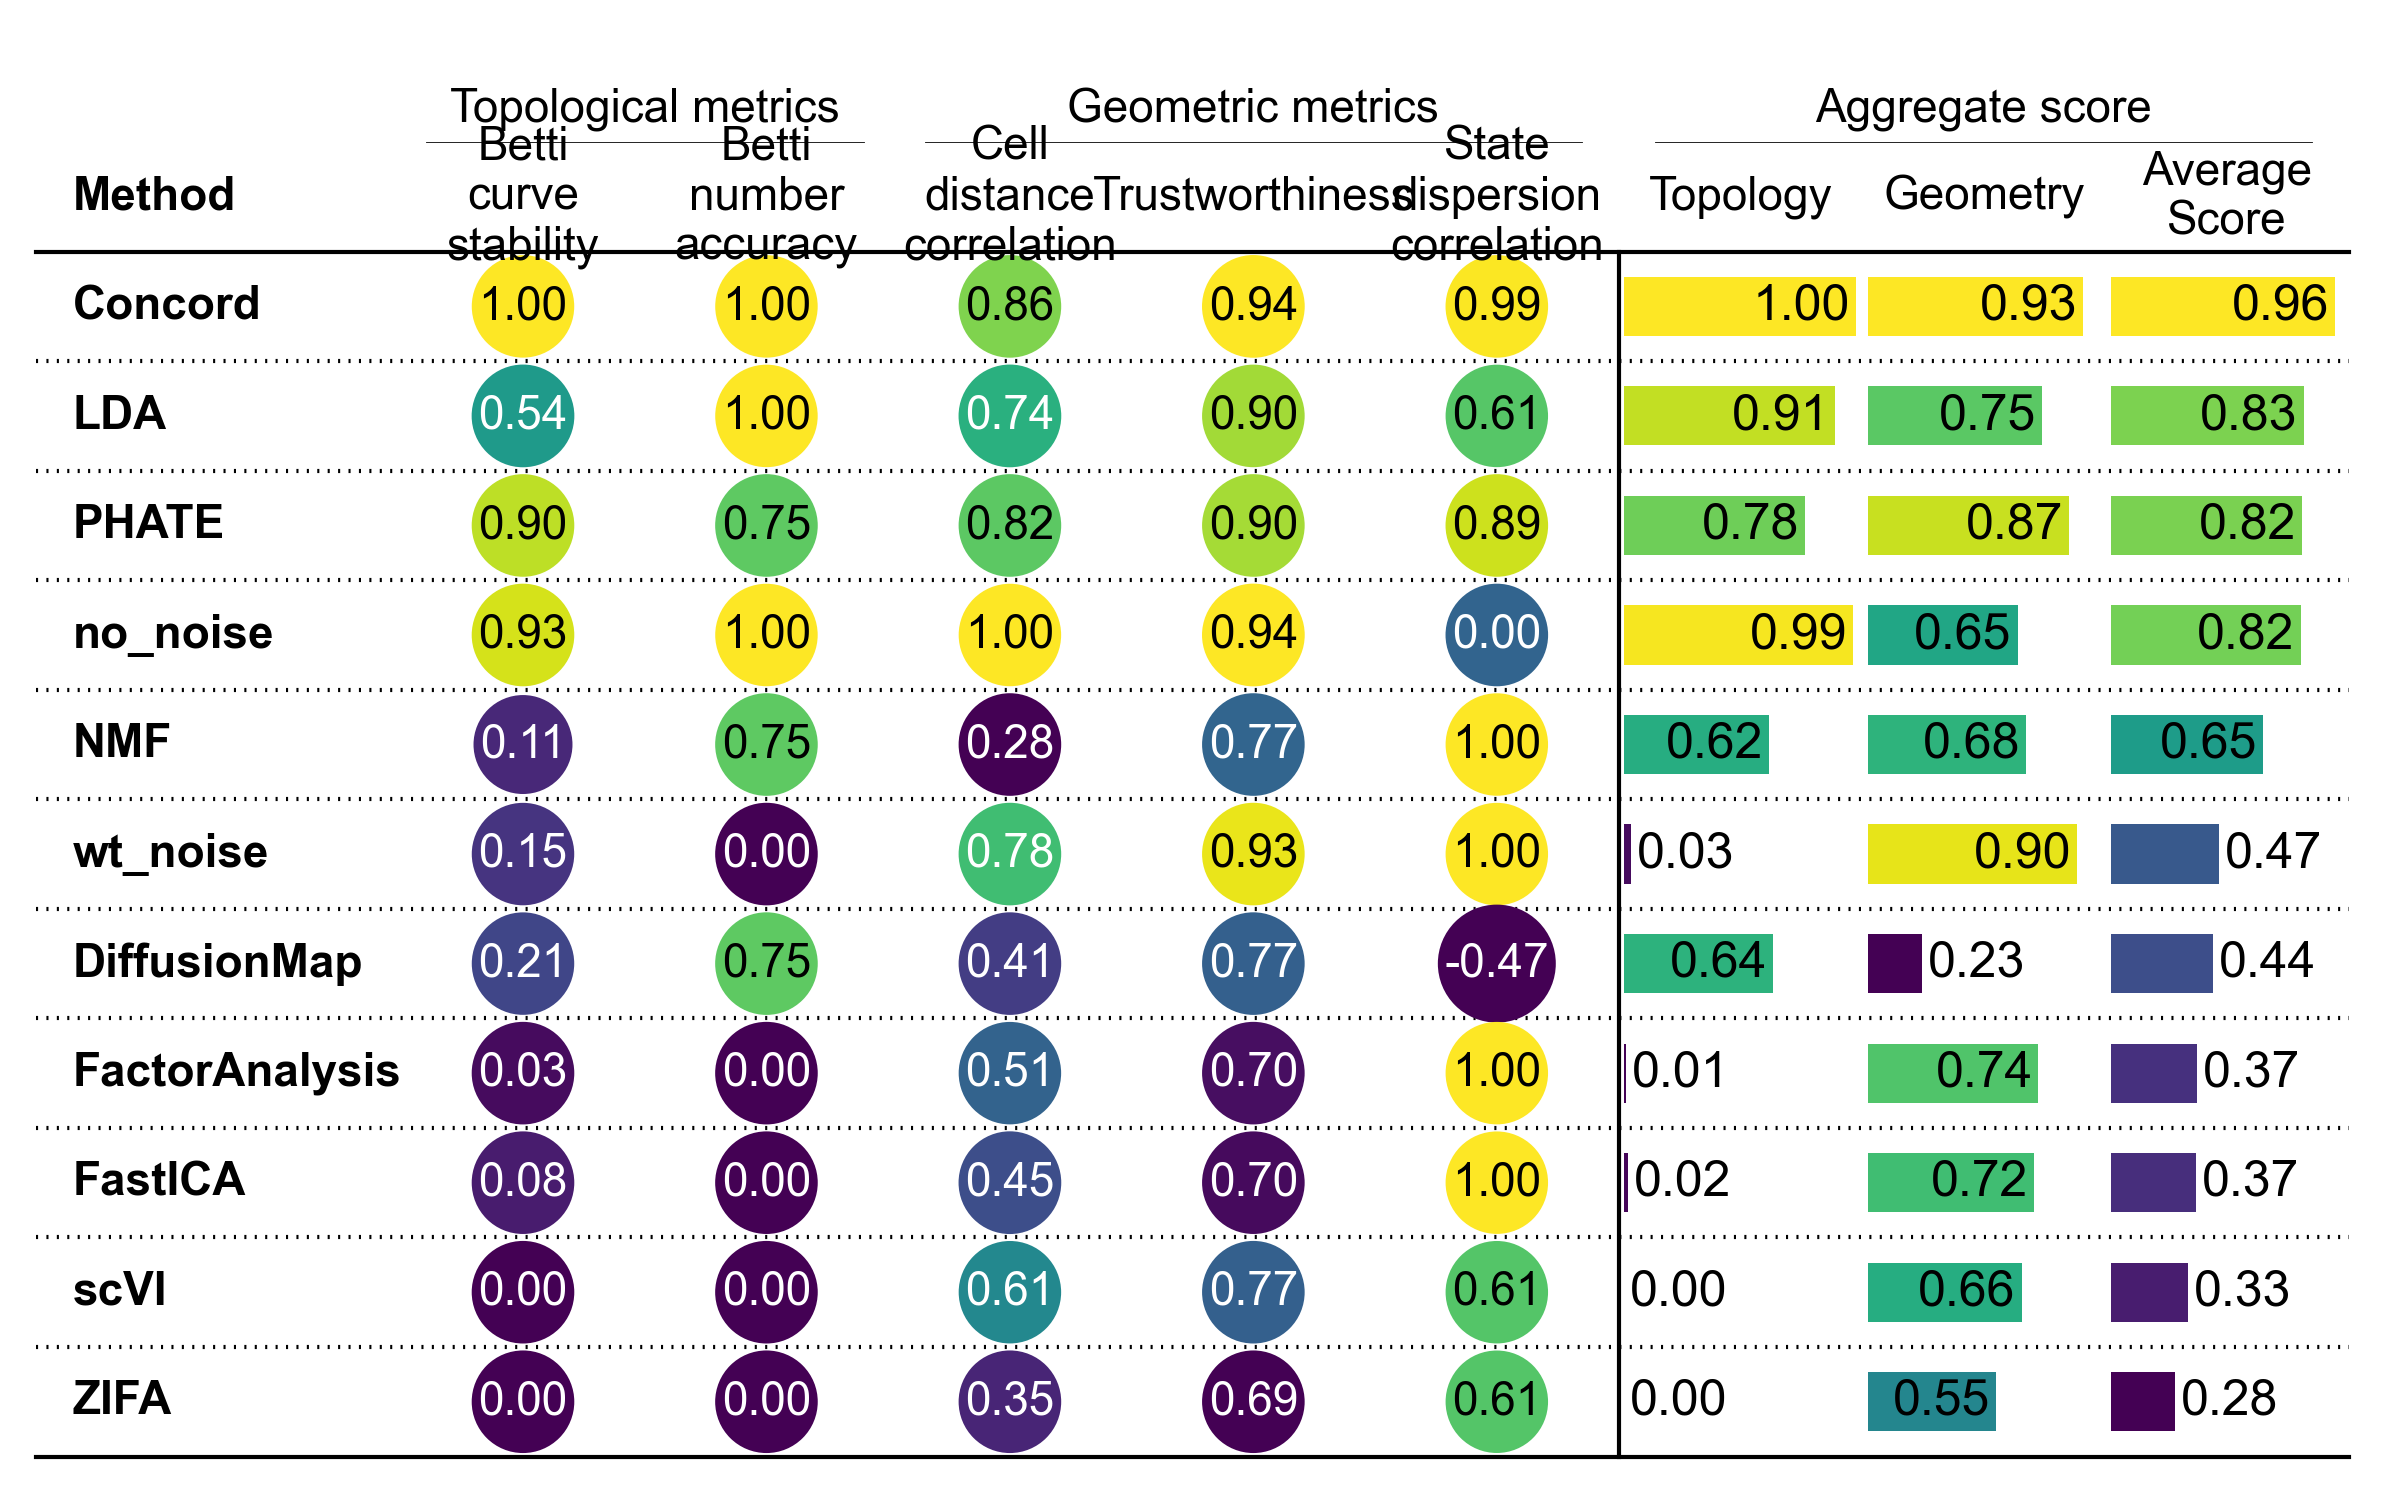

In [19]:
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_benchmark_table(all_scores, pal='viridis', pal_agg='viridis', cmap_method = 'minmax', agg_name = 'Aggregate score', save_path=save_dir / f"all_results_{file_suffix}.pdf", figsize=(10, 6.2), dpi=300)